In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
import glob

In [209]:
#Used for easier inspection of the columns and data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 300)

In [210]:
#Read in processed data
dfs = []
for filename in glob.glob('Processed_Data_*.csv'):
    dfs.append(pd.read_csv(filename))  
    
df = pd.concat(dfs, axis = 0, ignore_index = True)

In [211]:
#Create League Division mapping to be able to compute average leagues between players
values = [0, 1, 2, 3, 4, 5,
          6, 7, 8, 9, 10,
          11, 12, 13, 14, 15,
          16, 17, 18, 19, 20,
          21, 22, 23, 24, 25,
          26, 27, 28, 29, 30]

league_div = ['Bronze 0', 'Bronze 5', 'Bronze 4', 'Bronze 3', 'Bronze 2', 'Bronze 1',
              'Silver 5', 'Silver 4', 'Silver 3', 'Silver 2', 'Silver 1',
              'Gold 5', 'Gold 4', 'Gold 3', 'Gold 2', 'Gold 1',
              'Platinum 5', 'Platinum 4', 'Platinum 3', 'Platinum 2', 'Platinum 1',
              'Diamond 5', 'Diamond 4', 'Diamond 3', 'Diamond 2', 'Diamond 1',
              'Champion 5', 'Champion 4', 'Champion 3', 'Champion 2', 'Champion 1']

League_Div = pd.DataFrame(list(zip(league_div, values)), columns = ['League Division', 'Value'])

# 1. Does strict matchmaking actually improve the quality of matches?
## - How close are the matches? i.e. 3-0 3-1 3-2

In [212]:
#Separate into two groups, games with at least 1 person with limited matchmaking on and games with none
strict = df[(df['Limited_MM'] == 1) & (df['Solo_Queue'] == 1)]
strictGames = strict['Game_ID'].unique()
notStrict = df[(df['Limited_MM'] == 0) & (df['Solo_Queue'] == 1)]
notStrictGames = notStrict[~notStrict['Game_ID'].isin(strictGames)]['Game_ID'].unique()
strict = df[df['Game_ID'].isin(strictGames)].reset_index(drop = True)
notStrict = df[df['Game_ID'].isin(notStrictGames)].reset_index(drop = True)

In [213]:
#How close are matches
match_strict = strict.groupby(['Game_ID', 'Game_Score']).agg({'User_ID':'count'}).reset_index()

def get_score_diff(x):
    '''
    Calculate score differential between number of rounds won and number of rounds lost.
    '''
    if x in ['3-0', '0-3']:
        return(3)
    elif x in ['3-1', '1-3']:
        return(2)
    else:
        return(1)
    
match_strict['Score_Diff'] = match_strict['Game_Score'].apply(get_score_diff)
match_strict = match_strict[['Game_ID', 'Score_Diff']]
match_strict = match_strict.drop_duplicates(subset = ['Game_ID', 'Score_Diff'], keep = 'first')

In [214]:
match_strict['Score_Diff'].median()

2.0

In [215]:
match_strict['Score_Diff'].mean()

2.1507692307692308

In [216]:
1.96 * match_strict['Score_Diff'].std()/m.sqrt(len(match_strict))

0.05035604003348309

In [217]:
#How close are matches
match_notStrict = notStrict.groupby(['Game_ID', 'Game_Score']).agg({'User_ID':'count'}).reset_index()
match_notStrict['Score_Diff'] = match_notStrict['Game_Score'].apply(get_score_diff)
match_notStrict = match_notStrict[['Game_ID', 'Score_Diff']]
match_notStrict = match_notStrict.drop_duplicates(subset = ['Game_ID', 'Score_Diff'], keep = 'first')

In [218]:
match_notStrict['Score_Diff'].median()

2.0

In [219]:
match_notStrict['Score_Diff'].mean()

2.2435105067985166

In [220]:
#Compute 2 sample difference confidence interval

In [221]:
n1 = len(match_strict)
n2 = len(match_notStrict)
s1 = match_strict['Score_Diff'].std()
s2 = match_notStrict['Score_Diff'].std()

In [222]:
numerator = (n1 - 1)*s1**2 + (n2 - 1)*s2**2
denominator = n1 + n2 - 2
Sp = m.sqrt(numerator/denominator)

In [223]:
diff_mean = match_strict['Score_Diff'].mean() - match_notStrict['Score_Diff'].mean()

In [224]:
SE = Sp * m.sqrt(1/n1 + 1/n2)

In [225]:
diff_mean - 1.96 * SE

-0.1665026460398487

In [226]:
diff_mean + 1.96 * SE

-0.018979906018722945

### The 95% confidence interval of the mean difference round differential between the strict matchmaking games and the not strict matchmaking games is between (-0.167, -0.019). This means that we are 95% confident that the true mean difference is captured in that interval. Since it does not include 0, this shows that there is a difference between the two groups. So, this implies that on average, round scores tend to be closer when there is at least one person in the game with strict matchmaking turned on.

## - How close are the rounds?

In [227]:
#Track only 1 user for each game
Gameusers = strict[['Game_ID', 'User_ID']].drop_duplicates(subset = 'Game_ID', keep = 'first')
#Join on strict df to get all rounds for one user in each game
StrictuserDfAll = pd.merge(Gameusers, strict, how = 'left', on = ['Game_ID', 'User_ID'])

In [228]:
#Track only 1 user for each game
Gameusers = notStrict[['Game_ID', 'User_ID']].drop_duplicates(subset = 'Game_ID', keep = 'first')
#Join on notStrict df to get all rounds for one user in each game
notStrictuserDfAll = pd.merge(Gameusers, notStrict, how = 'left', on = ['Game_ID', 'User_ID'])

In [229]:
def get_all_metrics(x):
    '''
    creates a table of mean, median, and standard deviation for round length, total deaths, 
    and a few rank ordered metrics.
    '''
    
    #Remove infs from data. Happens when no one gets hurt during a round while scoring > 0 since
    #ScoreDamageRatio = Total Score / Damage Received
    df = x.copy()
    df['NetScoreDamageRatio1'] = df['NetScoreDamageRatio1'].replace([np.inf, -np.inf], np.nan).dropna()
    df['NetScoreDamageRatio2'] = df['NetScoreDamageRatio2'].replace([np.inf, -np.inf], np.nan).dropna()
    df['NetScoreDamageRatio3'] = df['NetScoreDamageRatio3'].replace([np.inf, -np.inf], np.nan).dropna()
    
    '''
    Convert NetTotalScore to remove negatives. It makes more sense to keep the negatives in a statistical 
    model but not while trying to track the score difference between two teams and computing
    the mean, standard deviation, and median.
    '''
    
    for num in ['1', '2', '3']:
        for var in ['NetTotalScore', 'NetScoreDamageRatio', 'NetScorePerSecond']:
            df[var+num] = abs(df[var+num])
    
    def get_metrics(col, single = True):
        '''
        helper function used in get_all_metrics and get_ranking_metrics. Used to return with a list of
        mean, median, standard deviation for a column.
        '''
        if single:
            metrics = [df[col].mean(), df[col].median(), df[col].std()]
        else:
            total = (df[col+'1'] + df[col+'2'] + df[col+'3'])
            metrics = [total.mean(), total.median(), total.std()]
        return metrics

    round_length = get_metrics('Round_Length')
    deaths = get_metrics('TotalDeaths')
    score1 = get_metrics('NetTotalScore1')
    score2 = get_metrics('NetTotalScore2')
    score3 = get_metrics('NetTotalScore3')
    score4 = get_metrics('NetTotalScore', False)
    sdr1 = get_metrics('NetScoreDamageRatio1')
    sdr2 = get_metrics('NetScoreDamageRatio2')
    sdr3 = get_metrics('NetScoreDamageRatio3')
    sdr4 = get_metrics('NetScoreDamageRatio', False)
    sps1 = get_metrics('NetScorePerSecond1')
    sps2 = get_metrics('NetScorePerSecond2')
    sps3 = get_metrics('NetScorePerSecond3')
    sps4 = get_metrics('NetScorePerSecond', False)
    
    table = pd.DataFrame(list(zip(round_length, deaths, score1, score2, score3, score4,
                                  sdr1, sdr2, sdr3, sdr4, sps1, sps2, sps3, sps4)),
                         columns = ['Round_Length', 'TotalDeaths', 'NetTotalScore1', 'NetTotalScore2', 'NetTotalScore3',
                                    'NetTotalScoreAll', 'NetScoreDamageRatio1', 'NetScoreDamageRatio2',
                                    'NetScoreDamageRatio3', 'NetScoreDamageRatioAll', 'NetScorePerSecond1',
                                    'NetScorePerSecond2', 'NetScorePerSecond3', 'NetScorePerSecondAll'])
    table.index = ['Mean', 'Median', 'SD']
    return table

In [230]:
strictTable = get_all_metrics(StrictuserDfAll)
notStrictTable = get_all_metrics(notStrictuserDfAll)

In [231]:
strictTable.transpose()

,Mean,Median,SD
Round_Length,90.487084,86.000000,28.349530
TotalDeaths,3.257523,3.000000,0.508315
NetTotalScore1,175.088486,152.802030,131.163109
NetTotalScore2,178.511952,166.527600,118.414696
NetTotalScore3,230.719522,215.000000,149.872578
NetTotalScoreAll,584.319960,562.800000,236.170037
NetScoreDamageRatio1,1.615943,1.043827,4.558724
NetScoreDamageRatio2,1.586059,0.953726,6.818380
NetScoreDamageRatio3,1.435951,0.830215,7.290570
NetScoreDamageRatioAll,4.637953,3.405704,17.551108


In [232]:
notStrictTable.transpose()

,Mean,Median,SD
Round_Length,90.340020,86.000000,28.453334
TotalDeaths,3.296942,3.000000,0.534612
NetTotalScore1,177.146948,150.492460,132.818337
NetTotalScore2,183.093045,165.750000,120.441235
NetTotalScore3,225.307982,203.000000,149.806660
NetTotalScoreAll,585.547974,567.334910,229.114411
NetScoreDamageRatio1,2.478684,1.076745,27.431087
NetScoreDamageRatio2,1.982302,0.983714,12.567599
NetScoreDamageRatio3,1.557969,0.826978,7.350446
NetScoreDamageRatioAll,6.018955,3.434715,41.178663


In [233]:
#Compute difference across 2 tables
diffTable = strictTable - notStrictTable
#Transpose for easier visualization
diffTable = diffTable.transpose()

In [234]:
def color_df(s):
    '''
    colors > 0 green and < 0 red
    '''
    is_negative = s < 0
    return ['background-color: #d65f5f' if v else 'background-color: #5fba7d' for v in is_negative]

In [235]:
diffTable.style.apply(color_df)

,Mean,Median,SD
Round_Length,0.147064,0,-0.103805
TotalDeaths,-0.0394185,0,-0.0262965
NetTotalScore1,-2.05846,2.30957,-1.65523
NetTotalScore2,-4.58109,0.7776,-2.02654
NetTotalScore3,5.41154,12,0.0659178
NetTotalScoreAll,-1.22801,-4.53491,7.05563
NetScoreDamageRatio1,-0.862741,-0.0329184,-22.8724
NetScoreDamageRatio2,-0.396243,-0.0299884,-5.74922
NetScoreDamageRatio3,-0.122018,0.00323626,-0.0598757
NetScoreDamageRatioAll,-1.381,-0.0290114,-23.6276


### On average, the net difference of ScorePerSecond between all players in a strict match making game round is higher than players in a regular game round. This implies that the players are more evenly matched in a regular game because lower NetScorePerSecond values imply the teams involved in the game are closer in skill level. However, this is not completely conclusive because ScorePerSecond is computed based on Score divided by Round Length. If there are bigger periods of gaps between actual fighting in a round, the ScorePerSecond values will naturally decrease. The standard deviation of NetScorePerSecond is consistently higher in the strict matchmaking group which indicate that there is a greater spread of values compared to regular games. One interpretation of this could be that because in strict matchmaking games, the player skill level is theoretically similar, so the main difference can be attributed to team composition (which is very important in the game) and some games, one comp may be dramatically better than another, resulting in high NetScorePerSecond values whereas some games are naturally going to be closer due to similar comp strength. Some comps are also more defensive in nature compared to other comps which can also help explain the lower values. In regular games, there is more random noise, so achieving the same conditions as a strict matchmaking game is harder, resulting in more consistent values.

### The round length for strict matchmaking games is very slightly higher on average and has less spread compared to regular games.

### Overall, because the NetTotalScoreAll is negative, this means that the scores as a whole in strict matchmaking games are closer between the two teams compared to regular games. The higher standard deviation in the strict matchmaking group implies a greater range of differences likely for the same reason for the NetScorePerSecond as explained above from comp strength. On average, there are more closer rounds than spread apart rounds in the strict matchmaking group.

### The observations are similar when looking at the NetScoreDamageRatio values. The negative values imply that in strict matchmaking games, players on both teams take more similar amounts of damage for how much they score compared to players in a regular game. This shows that players are more evenly matched in strict matchmaking games. The negative standard deviation values also support this in that there is less spread across all the rounds. ScoreDamageRatio in general is a better metric than ScorePerSecond when trying to determine the skill disparity between two players or two teams. If you do dramatically more damage than damage you take, that's a clear indicator that you are properly utilizing offensive and defensive abilities. Whereas a higher ScorePerSecond value could represent someone doing a lot of damage in a short period of time, but also taking a lot of damage and dying to maintain a high ScorePerSecond value. Because there is more spread in NetScoreDamageRatio in regular game rounds in general, this implies that there are more games when one team dominates the other i.e. the best player on one team targeting the weakest player on the other team. There is a much greater chance of a "weak link" in a regular game compared to a strict matchmaking game.

## - How spread apart are the league/divisions?

In [236]:
#Track only 1 user for each game
strictGames = strict.drop_duplicates(subset = 'Game_ID')
notStrictGames = notStrict.drop_duplicates(subset = 'Game_ID')

In [237]:
def get_ranking_metrics(x): 
    
    '''
    Convert NetTotalScore to remove negatives. It makes more sense to keep the negatives in a statistical 
    model but not while trying to track the score difference between two teams and computing
    the mean, standard deviation, and median.
    '''
    
    df = x.copy()
    
    for num in ['1', '2', '3']:
        df['NetLeagueDivisionValue'+num] = abs(df['NetLeagueDivisionValue'+num])
    
    def get_metrics(col, single = True):
        '''
        helper function used in get_all_metrics and get_ranking_metrics. Used to return with a list of
        mean, median, standard deviation for a column.
        '''
        if single:
            metrics = [df[col].mean(), df[col].median(), df[col].std()]
        else:
            total = (df[col+'1'] + df[col+'2'] + df[col+'3'])
            metrics = [total.mean(), total.median(), total.std()]
        return metrics
    
    
    league1 = get_metrics('NetLeagueDivisionValue1')
    league2 = get_metrics('NetLeagueDivisionValue2')
    league3 = get_metrics('NetLeagueDivisionValue3')
    league4 = get_metrics('NetLeagueDivisionValue', False)
    
    table = pd.DataFrame(list(zip(league1, league2, league3, league4)),
                         columns = ['NetLeagueDivision1', 'NetLeagueDivision2', 
                                    'NetLeagueDivision3', 'NetLeagueDivisionAll'])
    table.index = ['Mean', 'Median', 'SD']
    return table

In [238]:
strictTable2 = get_ranking_metrics(strictGames)
notStrictTable2 = get_ranking_metrics(notStrictGames)

In [239]:
strictTable2

,NetLeagueDivision1,NetLeagueDivision2,NetLeagueDivision3,NetLeagueDivisionAll
Mean,1.936410,1.883077,1.892308,5.711795
Median,2.000000,2.000000,2.000000,5.000000
SD,1.461363,1.396193,1.466845,2.677769


In [240]:
notStrictTable2

,NetLeagueDivision1,NetLeagueDivision2,NetLeagueDivision3,NetLeagueDivisionAll
Mean,3.119901,3.152040,3.244747,9.516687
Median,3.000000,3.000000,3.000000,9.000000
SD,2.511698,2.552978,2.634393,5.217548


In [241]:
#Differences
diffTable2 = strictTable2 - notStrictTable2

In [242]:
diffTable2.style.apply(color_df)

,NetLeagueDivision1,NetLeagueDivision2,NetLeagueDivision3,NetLeagueDivisionAll
Mean,-1.18349,-1.26896,-1.35244,-3.80489
Median,-1,-1,-1,-4
SD,-1.05033,-1.15679,-1.16755,-2.53978


### This shows that the strict matchmaking option is working properly since it should be aiming to minimize the differences of rankings between the involved players in the game. On average, the ranking differential in regular games is much higher and a greater spread of differences compared to strict matchmaking games.

# 2. How often does triple DPS win against support teams in solo queue?

In [243]:
#Filter to solo queue only
SQ = df[df['Solo_Queue'] == 1].reset_index(drop = True)

In [244]:
len(SQ['Game_ID'].unique())

1784

### Sample size is low. There are only 1784 unique solo queue games tracked in the data.

In [245]:
def game_won(x):
    '''
    to determine if a match is won or not based on the Game_Score column.
    '''
    if x[0] == '3':
        return 1
    else:
        return 0
SQ['Game_Won'] = SQ['Game_Score'].apply(game_won)  

In [246]:
#Compute trade column i.e. if near consecutive deaths occurred (one for each team)

def compute_trade(x):
    '''
    find if any trades were made with the reference person on team.
    '''
    traded = []
    if (abs(x['Time_Alive'] - x['Enemy1TimeAlive']) <= 5 and x['Deaths'] == 1 and x['Enemy1Deaths'] == 1):
        traded.append('Enemy1')
    if (abs(x['Time_Alive'] - x['Enemy2TimeAlive']) <= 5 and x['Deaths'] == 1 and x['Enemy2Deaths'] == 1):
        traded.append('Enemy2')
    if (abs(x['Time_Alive'] - x['Enemy3TimeAlive']) <= 5 and x['Deaths'] == 1 and x['Enemy3Deaths'] == 1):
        traded.append('Enemy3')
    if len(traded) > 0:
        return traded
    else:
        return(np.NaN)

def compute_trade_ally1(x):
    '''
    find if any trades were made with ally1.
    '''
    traded = []
    if (abs(x['Ally1TimeAlive'] - x['Enemy1TimeAlive']) <= 5 and x['Ally1Deaths'] == 1 and x['Enemy1Deaths'] == 1):
        traded.append('Enemy1')
    if (abs(x['Ally1TimeAlive'] - x['Enemy2TimeAlive']) <= 5 and x['Ally1Deaths'] == 1 and x['Enemy2Deaths'] == 1):
        traded.append('Enemy2')
    if (abs(x['Ally1TimeAlive'] - x['Enemy3TimeAlive']) <= 5 and x['Ally1Deaths'] == 1 and x['Enemy3Deaths'] == 1):
        traded.append('Enemy3')
    if len(traded) > 0:
        return traded
    else:
        return(np.NaN)

def compute_trade_ally2(x):
    '''
    find if any trades were made with ally2.
    '''
    traded = []
    if (abs(x['Ally2TimeAlive'] - x['Enemy1TimeAlive']) <= 5 and x['Ally2Deaths'] == 1 and x['Enemy1Deaths'] == 1):
        traded.append('Enemy1')
    if (abs(x['Ally2TimeAlive'] - x['Enemy2TimeAlive']) <= 5 and x['Ally2Deaths'] == 1 and x['Enemy2Deaths'] == 1):
        traded.append('Enemy2')
    if (abs(x['Ally2TimeAlive'] - x['Enemy3TimeAlive']) <= 5 and x['Ally2Deaths'] == 1 and x['Enemy3Deaths'] == 1):
        traded.append('Enemy3')
    if len(traded) > 0:
        return traded
    else:
        return(np.NaN)
    

SQ['Traded'] = SQ.apply(compute_trade, axis = 1)
SQ['Ally1Traded'] = SQ.apply(compute_trade_ally1, axis = 1) 
SQ['Ally2Traded'] = SQ.apply(compute_trade_ally2, axis = 1) 

In [247]:
#Compute column to calculate average of all player's league_division
def compute_match_rating(x):
    '''
    find the average league of all the players.
    '''
    total_rating = x['TeamLeagueDivisionValue1'] + x['TeamLeagueDivisionValue2'] +  x['TeamLeagueDivisionValue3'] + \
                   x['EnemyLeagueDivisionValue1'] + x['EnemyLeagueDivisionValue2'] + x['EnemyLeagueDivisionValue3']
    
    #Ignore Bronze 0 aka placement
    total_without_placement = 6
    for num in ['1', '2', '3']:
        for var in ['TeamLeagueDivisionValue', 'EnemyLeagueDivisionValue']:
            if x[var+num] == 0:
                num_placement -= 1

    avg_rating = round(total_rating/total_without_placement)
    
    league_div = League_Div[League_Div['Value'] == avg_rating]['League Division'].values[0]
    
    return league_div

In [248]:
SQ['MatchLeagueDivision'] = SQ.apply(compute_match_rating, axis = 1)
SQ['MatchLeague'] = SQ['MatchLeagueDivision'].str[:-2]

In [249]:
def compute_time_first_death(x):
    '''
    find the time when the first death occurred.
    '''
    return min(x['Time_Alive'], x['Ally1TimeAlive'], x['Ally2TimeAlive'], x['Enemy1TimeAlive'], x['Enemy2TimeAlive'],
               x['Enemy3TimeAlive'])

def compute_first_to_die(x):
    '''
    determine if someone from the team died first or someone from the enemy.
    '''
    if x['TimeFirstDeath'] in [x['Time_Alive'], x['Ally1TimeAlive'], x['Ally2TimeAlive']]:
        return('Team')
    else:
        return('Enemy')
    
def compute_death_times(x):
    '''
    output an ordered list from earliest to latest death times for the enemy team only for winning rounds.
    '''
    
    if x['Round_Won'] == 1:
        sorted_deaths = np.sort(np.array([x['Enemy1TimeAlive'], x['Enemy2TimeAlive'], x['Enemy3TimeAlive']]))
        return sorted_deaths
    else:
        deaths = []
        if x['Enemy1Deaths'] == 1:
            deaths.append(x['Enemy1TimeAlive'])
        if x['Enemy2Deaths'] == 1:
            deaths.append(x['Enemy2TimeAlive'])
        if x['Enemy3Deaths'] == 1:
            deaths.append(x['Enemy3TimeAlive'])
         
        if len(deaths) > 0:
            sorted_deaths = np.sort(np.array([x['Enemy1TimeAlive'], x['Enemy2TimeAlive'], x['Enemy3TimeAlive']]))
            return sorted_deaths
        else:    
            return(np.NaN)
        
def compute_first_ally_death(x):
    '''
    find the time when the first ally died.
    '''

    if np.array([x['Deaths'] + x['Ally1Deaths'] + x['Ally2Deaths']]).sum() > 0:
        return(min(x['Time_Alive'], x['Ally1TimeAlive'], x['Ally2TimeAlive']))
    else:
        return(np.NaN)
    
def first_death_traded(x):
    '''
    determine if the first death of the game was a trade.
    '''
    if pd.notnull(x['TeamTimeDeath1']) and pd.notnull(x['EnemyTimeDeath1']):
        if abs(x['TeamTimeDeath1'] - x['EnemyTimeDeath1']) <= 5:
            return 1
        else:
            return 0
    else:
        return 0
    
SQ['TeamTimeDeath1'] = SQ.apply(compute_first_ally_death, axis = 1)
SQ['EnemyDeathTimes'] = SQ.apply(compute_death_times, axis = 1)



'''
EnemyTimeDeath1 stores the time alive for the first enemy that died for convenience.
EnemyTimeDeath2 and EnemyTimeDeath3 tracks the time passed since the previous death.
TradedAny determines if a trade occurred throughout the course of the round.
'''
SQ['EnemyTimeDeath1'] = np.NaN
SQ['EnemyTimeDeath2'] = np.NaN
SQ['EnemyTimeDeath3'] = np.NaN

SQ['TradedAny'] = 0

for index, row in SQ.iterrows():
    if row['Round_Won'] == 1:
        death1 = row['EnemyDeathTimes'][0]
        diff1 = row['EnemyDeathTimes'][1] - row['EnemyDeathTimes'][0]
        diff2 = row['EnemyDeathTimes'][2] - row['EnemyDeathTimes'][1]
        SQ.loc[index, 'EnemyTimeDeath1'] = death1
        SQ.loc[index, 'EnemyTimeDeath2'] = diff1
        SQ.loc[index, 'EnemyTimeDeath3'] = diff2
    else:
        if (row['Enemy1Deaths'] + row['Enemy2Deaths'] + row['Enemy3Deaths']) > 0:
            death1 = row['EnemyDeathTimes'][0]
            SQ.loc[index, 'EnemyTimeDeath1'] = death1
            
            if len(row['EnemyDeathTimes']) == 2:
                diff1 = row['EnemyDeathTimes'][1] - row['EnemyDeathTimes'][0]
                SQ.loc[index, 'EnemyTimeDeath2'] = diff1
                
    if type(row['Traded']) == list or type(row['Ally1Traded']) == list or type(row['Ally2Traded']) == list:
        SQ.loc[index, 'TradedAny'] = 1

SQ['TimeFirstDeath'] = SQ.apply(compute_time_first_death, axis = 1)
SQ['TeamEnemyFirstDeath'] = SQ.apply(compute_first_to_die, axis = 1)
SQ['FirstDeathTraded'] = SQ.apply(first_death_traded, axis = 1)

## - Overall win rate

In [250]:
#Possible Triple DPS comps
tripleDPS = ['MELEE, MELEE, RANGED', 'MELEE, MELEE, MELEE', 'RANGED, RANGED, RANGED', 'RANGED, RANGED, MELEE']

In [251]:
#Filter to games only with Triple DPS vs support comps
dfTripleDPS = SQ[(SQ['Team_Roles'].isin(tripleDPS)) & (~SQ['Enemy_Roles'].isin(tripleDPS))]

In [252]:
#1 user per game
TripleDPSOutcomes = dfTripleDPS.drop_duplicates(subset = ['Game_ID', 'Game_Score'], keep = 'first')


Gameusers = dfTripleDPS[['Game_ID', 'User_ID']].drop_duplicates(subset = 'Game_ID', keep = 'first')

#1 user per each game every round
TripleDPSOutcomes2 = pd.merge(Gameusers, dfTripleDPS, how = 'left', on = ['Game_ID', 'User_ID'])

In [253]:
TripleDPSOutcomes['Game_Won'].mean()

0.43783783783783786

In [254]:
len(TripleDPSOutcomes)

370

### Overall, a Triple DPS team has about a 43.78% chance to win against a team with at least one support in a sample size of 370 qualifying games.

## - By map

In [255]:
def create_agg(aggGroup, newcolname):
    '''
    Create aggregated df and prepare data to be plotted.
    '''
    groupDf = TripleDPSOutcomes.groupby(aggGroup).agg({'Game_Won':'mean', 'Game_ID':'count'}).reset_index().\
    sort_values(by = 'Game_Won', ascending = False).reset_index(drop = True)
    
    groupDf.columns = [newcolname, 'Win Percent', 'Count']
    groupDf['Win Percent'] = groupDf['Win Percent'] * 100
    
    return groupDf

In [256]:
def create_agg_plot(df, group, width, height):
    '''
    Create plot for aggregated data.
    '''
    #Create plot
    plt.figure(figsize=(width , height))
    sns.set(font_scale = 1.1)
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelweight'] = 'bold'
    ax = sns.barplot(data = df, x = 'Win Percent', y = group)
    
    #Set limit between 0 and 100%
    plt.xlim(0, 100)
    
    #Labels
    plt.ylabel(group, size = 17)
    plt.xlabel('Win Percent', size = 17)
    plt.title('Solo Queue Triple DPS VS Support Teams By {}'.format(group), size = 20, fontweight = 'bold')
    
    #Text labels
    for index, row in df.iterrows():
        label = str(round(row['Win Percent'], 1)) + '% (' + str(row['Count']) + ')'
        ax.text(row['Win Percent'], row.name, label, color = 'black', ha = 'left')
        
    return ax

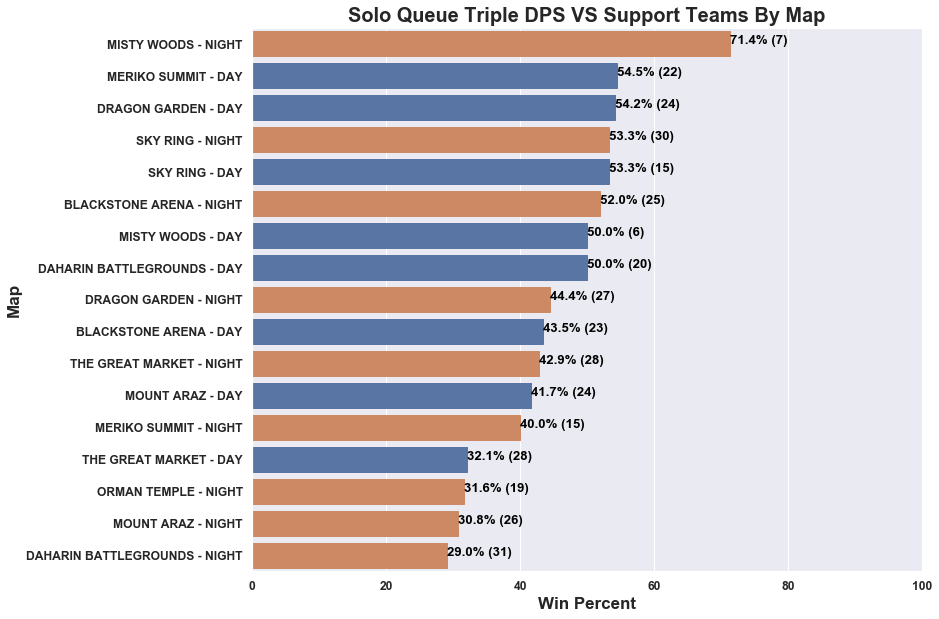

In [257]:
MapDf = create_agg('Map', 'Map')
MapDf['Type'] = MapDf['Map'].str.split(' ').str[-1]

ax = create_agg_plot(MapDf, 'Map', 12, 10)
#Color bars based on night vs day
for i, bar in enumerate(ax.patches):
    if MapDf.loc[i, 'Type'] == 'NIGHT':
        bar.set_color('#CC8963')
    else:
        bar.set_color('#5975A4')

#Save to file
plt.savefig('TripleDPSMap.png',  bbox_inches = 'tight')

### The best map is Misty Woods - Night resulting in a 71.4% chance to win, although the sample size is much lower compared to most of the other maps. Meriko Summit - Day, Dragon Garden - Day, Sky Ring - Night, Sky Ring - Day, and Blackstone Arena - Night are strong contenders with all win percents > 50%.

### Daharin Battlegrounds - Night, Mount Araz - Night, Orman Temple - Night, and The Great Market - Day are the worst maps with win percents < 40%.

### As far as why these maps are better/worse than the other maps is not entirely clear as it can also be dependent on team comp vs enemy comp.

### It may also be due to chance due to a relatively low sample size and slight bias because high rated players tend to avoid playing triple DPS whenever possible.

## - By league/elo

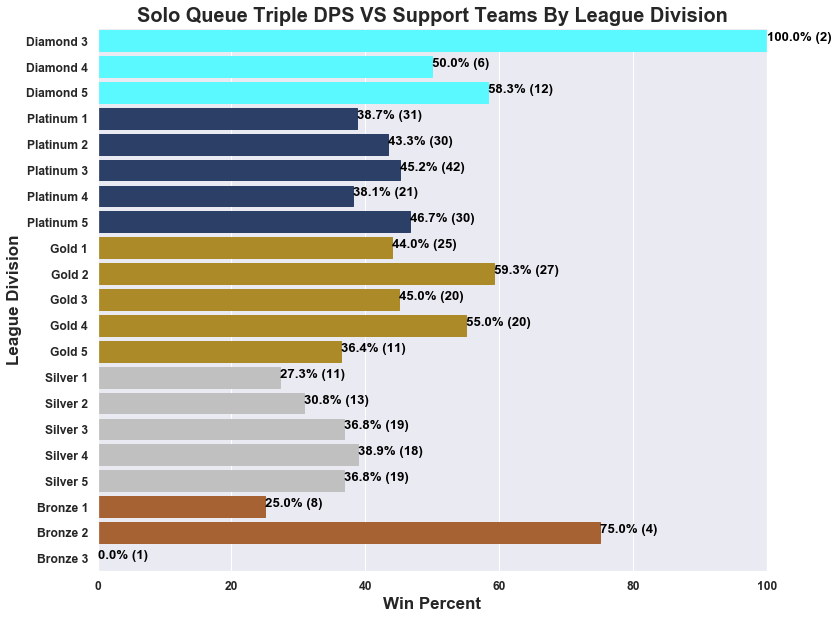

In [258]:
LeagueDivisionDf = TripleDPSOutcomes.groupby('MatchLeagueDivision').agg({'Game_Won':'mean', 'Game_ID':'count'}).reset_index()

LeagueDivisionDf.columns = ['League Division', 'Win Percent', 'Count']
LeagueDivisionDf['Win Percent'] = LeagueDivisionDf['Win Percent'] * 100

#Group and order by league division
LeagueDivisionDf['League Division'] = pd.Categorical(LeagueDivisionDf['League Division'],
                                                    ['Diamond 3', 'Diamond 4', 'Diamond 5',
                                                     'Platinum 1', 'Platinum 2', 'Platinum 3', 'Platinum 4', 'Platinum 5',
                                                     'Gold 1', 'Gold 2', 'Gold 3', 'Gold 4', 'Gold 5',
                                                     'Silver 1', 'Silver 2', 'Silver 3', 'Silver 4', 'Silver 5',
                                                     'Bronze 1', 'Bronze 2', 'Bronze 3'])

LeagueDivisionDf = LeagueDivisionDf.sort_values(by = 'League Division').reset_index(drop = True)

LeagueDivisionDf['Type'] = LeagueDivisionDf['League Division'].str.split(' ').str[0]

plt.figure(figsize=(12 , 10))
sns.set(font_scale = 1.1)
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
ax = sns.barplot(data = LeagueDivisionDf, x = 'Win Percent', y = 'League Division')

#Set limit between 0 and 100%
plt.xlim(0, 100)

#Labels
plt.ylabel('League Division', size = 17)
plt.xlabel('Win Percent', size = 17)
plt.title('Solo Queue Triple DPS VS Support Teams By {}'.format('League Division'), size = 20, fontweight = 'bold')

#Text labels
for index, row in LeagueDivisionDf.iterrows():
    label = str(round(row['Win Percent'], 1)) + '% (' + str(row['Count']) + ')'
    ax.text(row['Win Percent'], row.name, label, color = 'black', ha = 'left')
    
#Color bars based on league
for i, bar in enumerate(ax.patches):
    if LeagueDivisionDf.loc[i, 'Type'] == 'Diamond':
        bar.set_color('#5AF8FF')
    elif LeagueDivisionDf.loc[i, 'Type'] == 'Platinum':
        bar.set_color('#2C3F67')
    elif LeagueDivisionDf.loc[i, 'Type'] == 'Gold':
        bar.set_color('#AC8A28')
    elif LeagueDivisionDf.loc[i, 'Type'] == 'Silver':
        bar.set_color('#C0C0C0')
    else:
        bar.set_color('#A66232')
        
#Save to file
plt.savefig('TripleDPSLeagueDivision.png',  bbox_inches = 'tight')


### Due to low sample sizes, the results above are not too clear other than that a Triple DPS team averaging Diamond League has the best chance to win as Triple DPS because they better understand the game compared to lower league players. They know how to properly punish players for their mistakes whereas a lower rated Triple DPS team may not be playing aggresive enough to take down a team with a support.

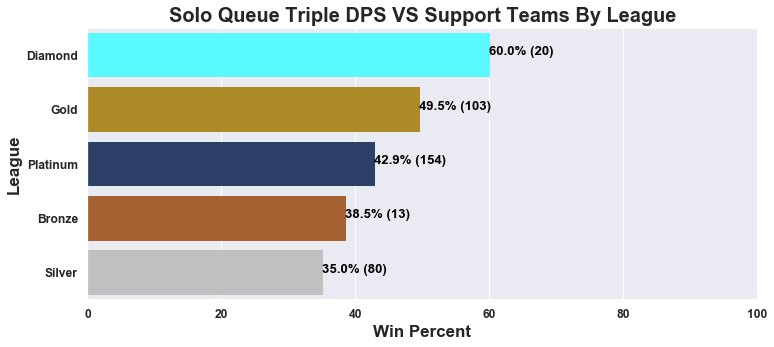

In [259]:
LeagueDf = create_agg('MatchLeague', 'League')

ax = create_agg_plot(LeagueDf, 'League', 12, 5)

#Color bars based on league
for i, bar in enumerate(ax.patches):
    if LeagueDf.loc[i, 'League'] == 'Diamond':
        bar.set_color('#5AF8FF')
    elif LeagueDf.loc[i, 'League'] == 'Platinum':
        bar.set_color('#2C3F67')
    elif LeagueDf.loc[i, 'League'] == 'Gold':
        bar.set_color('#AC8A28')
    elif LeagueDf.loc[i, 'League'] == 'Silver':
        bar.set_color('#C0C0C0')
    else:
        bar.set_color('#A66232')
        
#Save to file
plt.savefig('TripleDPSLeague.png',  bbox_inches = 'tight')

### Similar to the last plot, Triple DPS teams averaging Diamond league have the highest chance to win. Again, this may also be due to low sample size and the data containing only the first few days of a new season.

### Silver and Bronze are consistently at the bottom which makes sense because they haven't learned how to play the game properly yet. It is somewhat strange that Gold League performs better than Platinum League and without knowing the difference between the average player in both of these leagues, it is hard to conclude anything.

## -By Team_Role

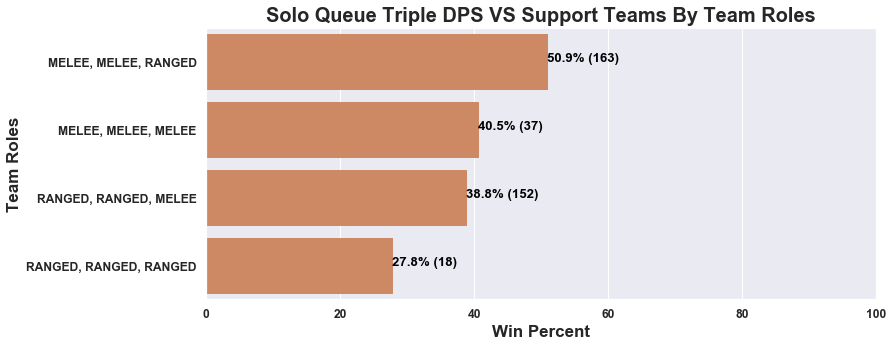

In [260]:
TeamRolesDf = create_agg('Team_Roles', 'Team Roles')
ax = create_agg_plot(TeamRolesDf, 'Team Roles', 12, 5)
#Color bars
for i, bar in enumerate(ax.patches):
    bar.set_color('#CC8963')
    
#Save to file
plt.savefig('TripleDPSTeamRoles.png',  bbox_inches = 'tight')

### From the plot above it's clear that the best Triple DPS comp consists of two melee champions and one ranged champion while the worst is triple ranged.

## -By Enemy_Role

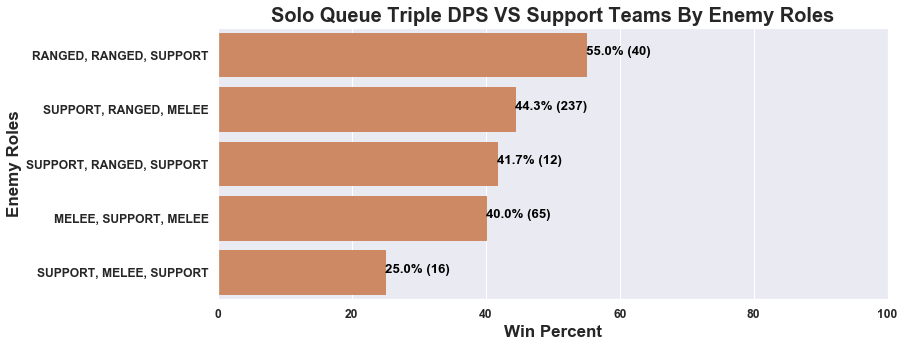

In [261]:
EnemyRolesDf = create_agg('Enemy_Roles', 'Enemy Roles')
ax = create_agg_plot(EnemyRolesDf, 'Enemy Roles', 12, 5)
#Color bars
for i, bar in enumerate(ax.patches):
    bar.set_color('#CC8963')
    
#Save to file
plt.savefig('TripleDPSEnemyRoles.png',  bbox_inches = 'tight')

### Triple DPS teams appears to perform best against double ranged support teams and the worst against double support melee.

### This may be due to the fact that double melee ranged is the most common triple DPS comp and from a comp perspective, that should perform well against a double ranged comp regardless of actual champions.

### Double melee has the ability to push double ranged comps back for mid control. It may also be more deadly for the enemy team if their support is a melee support such as Ulric or especially Sirius because it puts them at the frontlines. We know about that Space Q Sirius syndrome. 

## -By EnemyRolesDetail

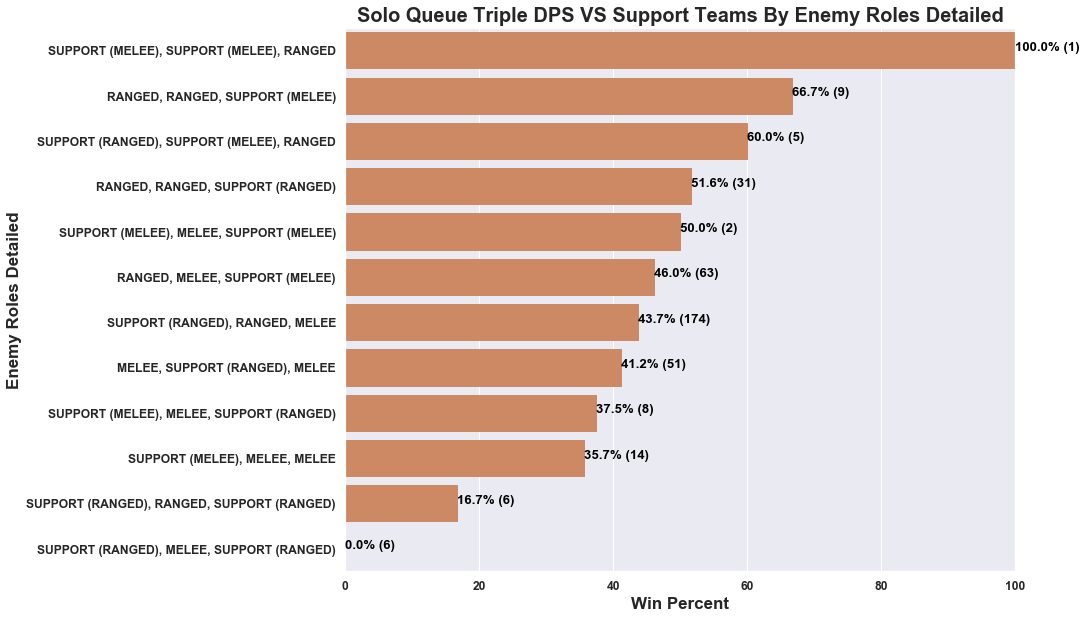

In [262]:
EnemyDetailRolesDf = create_agg('EnemyRolesDetail', 'Enemy Roles Detailed')
ax = create_agg_plot(EnemyDetailRolesDf, 'Enemy Roles Detailed', 12, 10)
#Color bars
for i, bar in enumerate(ax.patches):
    bar.set_color('#CC8963')
    
#Save to file
plt.savefig('TripleDPSEnemyRolesDetailed.png',  bbox_inches = 'tight')

### There are quite a few groups with low sample size, particularly the different combinations of double support + DPS. Universally, it is understood that the best comp is a balanced comp containing 1 melee, 1 ranged, and 1 support champion. The melee champion creates space for the ranged champion to be more effective, and the support champion provides protection.

### When one or more roles are missing, certain weaknesses become apparent. For an example, if there is no melee champion, the team will constantly be shoved back and have no mid control. So for most cases, people do not try to pick an inbalanced comp with the well understood notion that it doesn't perform well. Usually when they happen, it's because players that only play one hero happen to land on the same team.

### Our top result with 100% win rate only has one game, specifically against Ulric, Sirius, and a ranged champion. Comp wise, I can tell you that this is not a good comp. It's more optimal of one of Sirius or Ulric was swapped out for a melee DPS champion so they can utilize their space ability to follow the melee ally after they jump in to heal their ally and put pressure on the enemy. Still, the victory against this team could have happened by random chance.

### In general, no big conclusion can be drawn about the low sample groups despite that it appears that Triple DPS does well against ranged, ranged, support(melee) and bad against support (ranged), melee, support (ranged) and support (ranged), ranged, support(ranged).

### The result of any of these percentages could have been caused by specific matchups. Comp match up contributes a great deal of whether or not your team can win a round or game. A bad comp means that you have to severely outplay your opponents to win which in most cases, doesn't happen.

### Because there is a variety of different comps of Triple DPS combined with the different double support + DPS comps, one specific match up might be over or under represented. For an example, a triple ranged DPS comp will undoubtly do poorly against an Oldur, Pearl, and Shifu.

### Without examining the exact comp match ups against each combination of double support + DPS, we can't generalize anything about triple DPS win rate against them. And if we were to split it up that way, we would only likely have a few samples within each group because the sample sizes are low and the results of those matchups could have been attributed to random chance.

### We can see that within the single support combinations, Triple DPS performs the best against ranged, ranged, support (ranged) with a win percent of 51.6%. Considering that the overall win rate for Triple DPS is 44%, this is very good. Going back to our previous discussion, this makes sense because of the lack of forward pressure and being shoved back, losing mid control.

### On the other hand, within this single support combination, Triple DPS performs the worst against support (melee), melee, melee. The way I see this working is they will aim to rush down the ranged champion in the Triple DPS team. Since they have no support, the ranged champion should not be able to survive. Since most Triple DPS comps contain at least one ranged champion, seeing a low win percentage for this is not surprising.

## -How do Triple DPS commonly win rounds?

In [263]:
Gameusers = SQ[['Game_ID', 'User_ID']].drop_duplicates(subset = 'Game_ID', keep = 'first')
#1 user per each game every round
SQOutcomes = pd.merge(Gameusers, SQ, how = 'left', on = ['Game_ID', 'User_ID'])

In [264]:
SQOutcomesWin = SQOutcomes[SQOutcomes['Round_Won'] == 1]
SQOutcomesLose = SQOutcomes[(SQOutcomes['Round_Won'] == 0) & (SQOutcomes['Round_Draw'] == 0)]

In [265]:
SQ.head(1)

,Game_ID,Map,Match_Type,Ranking_Type,Server_Type,Solo_Queue,Region,Limited_MM,Name,User_ID,Champion,Role,Group,League,Division,Total_Time_Played,Account_Level,Champion_Level,Champion_Time_Played,Round,Kills,Deaths,Assists,Damage,Damage_Received,Protection,Protection_Received,Control,Control_Received,Energy_Used,Energy_Gained,Abilities_Used,Ultimates,Num_R,Num_EX1,Num_EX2,Num_Energy_Used,Orb_Kills,First_Orb,MVP,Round_Length,Round_Won,Total_Score,Highest_Score,Health_Shards,Energy_Shards,Team_Orbs,Enemy_Orbs,Time_Alive,Premade,Queue_Time,Ping,Avatar,Title,Outfit Rarity,Outfit,Attachment Rarity,Attachment,Pose Rarity,Pose,Mount Rarity,Mount,Battlerite 1,Battlerite 2,Battlerite 3,Battlerite 4,Battlerite 5,Battlerites,Team_Comp,Team_Roles,Ally1Role,Ally1Champion,Ally1ChampionPlayed,Ally1TotalPlayed,Ally1TotalScore,Ally1DamageReceived,Ally1TimeAlive,Ally1League,Ally1Ping,Ally1NumEnergyUsed,Ally1HighestScore,Ally1Battlerite1,Ally1Battlerite2,Ally1Battlerite3,Ally1Battlerite4,Ally1Battlerite5,Ally1Battlerites,Ally2Role,Ally2Champion,Ally2ChampionPlayed,Ally2TotalPlayed,Ally2TotalScore,Ally2DamageReceived,Ally2TimeAlive,Ally2League,Ally2Ping,Ally2NumEnergyUsed,Ally2HighestScore,Ally2Battlerite1,Ally2Battlerite2,Ally2Battlerite3,Ally2Battlerite4,Ally2Battlerite5,Ally2Battlerites,Enemy_Comp,Enemy_Roles,Enemy_Total_HealthShards,Enemy_Total_EnergyShards,Enemy1Role,Enemy1Champion,Enemy1ChampionPlayed,Enemy1TotalPlayed,Enemy1TotalScore,Enemy1DamageReceived,Enemy1TimeAlive,Enemy1League,Enemy1Ping,Enemy1NumEnergyUsed,Enemy1HighestScore,Enemy1Battlerite1,Enemy1Battlerite2,Enemy1Battlerite3,Enemy1Battlerite4,Enemy1Battlerite5,Enemy1Battlerites,Enemy2Role,Enemy2Champion,Enemy2ChampionPlayed,Enemy2TotalPlayed,Enemy2TotalScore,Enemy2DamageReceived,Enemy2TimeAlive,Enemy2League,Enemy2Ping,Enemy2NumEnergyUsed,Enemy2HighestScore,Enemy3Role,Enemy3Champion,Enemy3ChampionPlayed,Enemy3TotalPlayed,Enemy3TotalScore,Enemy3DamageReceived,Enemy3TimeAlive,Enemy3League,Enemy3Ping,Enemy3NumEnergyUsed,Enemy3HighestScore,Enemy2Battlerite1,Enemy2Battlerite2,Enemy2Battlerite3,Enemy2Battlerite4,Enemy2Battlerite5,Enemy2Battlerites,Enemy3Battlerite1,Enemy3Battlerite2,Enemy3Battlerite3,Enemy3Battlerite4,Enemy3Battlerite5,Enemy3Battlerites,Role_Detail,Ally1RoleDetail,Ally2RoleDetail,Enemy1RoleDetail,Enemy2RoleDetail,Enemy3RoleDetail,TeamRolesDetail,EnemyRolesDetail,BattleritesType,Ally1BattleritesType,Ally2BattleritesType,Enemy1BattleritesType,Enemy2BattleritesType,Enemy3BattleritesType,ScoreDamageRatio,Ally1ScoreDamageRatio,Ally2ScoreDamageRatio,Enemy1ScoreDamageRatio,Enemy2ScoreDamageRatio,Enemy3ScoreDamageRatio,ScorePerSecond,Ally1ScorePerSecond,Ally2ScorePerSecond,Enemy1ScorePerSecond,Enemy2ScorePerSecond,Enemy3ScorePerSecond,TeamTotalHealthShards,TeamTotalEnergyShards,Ally1Division,Ally1Damage,Ally1Protection,Ally1ProtectionReceived,Ally1Control,Ally1ControlReceived,Ally1EnergyUsed,Ally1EnergyGained,Ally1Deaths,Ally2Division,Ally2Damage,Ally2Protection,Ally2ProtectionReceived,Ally2Control,Ally2ControlReceived,Ally2EnergyUsed,Ally2EnergyGained,Ally2Deaths,Enemy1Division,Enemy1Damage,Enemy1Protection,Enemy1ProtectionReceived,Enemy1Control,Enemy1ControlReceived,Enemy1EnergyUsed,Enemy1EnergyGained,Enemy1Deaths,Enemy2Division,Enemy2Damage,Enemy2Protection,Enemy2ProtectionReceived,Enemy2Control,Enemy2ControlReceived,Enemy2EnergyUsed,Enemy2EnergyGained,Enemy2Deaths,Enemy3Division,Enemy3Damage,Enemy3Protection,Enemy3ProtectionReceived,Enemy3Control,Enemy3ControlReceived,Enemy3EnergyUsed,Enemy3EnergyGained,Enemy3Deaths,TotalDeaths,LeagueDivision,Ally1LeagueDivision,Ally2LeagueDivision,Enemy1LeagueDivision,Enemy2LeagueDivision,Enemy3LeagueDivision,TeamRatioUltimatesAll20,EnemyRatioUltimatesAll20,TeamRatioREX50,EnemyRatioREX50,NetHealthShards,NetEnergyShards,NetOrbs,NetDeathOrbs,TeamNetUltimates,TeamNetEX,TeamNetR,TeamDamage1,TeamDamage2,TeamDamage3,EnemyDamage1,EnemyDamage2,EnemyDamage3,TeamProtection1,TeamProtection2,TeamProtection3,EnemyProtection1,EnemyProtection2,EnemyProte

In [266]:
TripleDPSOutcomesWin = TripleDPSOutcomes2[TripleDPSOutcomes2['Round_Won'] == 1]
TripleDPSOutcomesLose = TripleDPSOutcomes2[(TripleDPSOutcomes2['Round_Won'] == 0) & (TripleDPSOutcomes2['Round_Draw'] == 0)]

In [267]:
TripleDPSOutcomesWin['TeamEnemyFirstDeath'].value_counts()

Enemy    564
Team      75
Name: TeamEnemyFirstDeath, dtype: int64

In [268]:
SQOutcomesWin['TeamEnemyFirstDeath'].value_counts()

Enemy    3120
Team      421
Name: TeamEnemyFirstDeath, dtype: int64

In [269]:
#Percent of rounds won with an ally dying before any enemies triple DPS teams
sum(TripleDPSOutcomesWin['TeamEnemyFirstDeath'] == 'Team')/len(TripleDPSOutcomesWin)

0.11737089201877934

In [270]:
#Percent of rounds won with an ally dying before any enemies solo queue overall
sum(SQOutcomesWin['TeamEnemyFirstDeath'] == 'Team')/len(SQOutcomesWin)

0.1188929680881107

### Triple DPS teams are 0.2% less likely to win a round if the first death in the game is on their team compared to solo queue overall.

In [271]:
def create_summary_table(df1, df2):
    '''
    create formatted table of various potential win metrics.
    '''
    
    all_tables = []
    
    for side in ['Team', 'Enemy']:
    
        Propdeath1traded = []
        Propanytraded = []
        Propfirstorb = []
        Propnetorbs = []
        roundlength = []
        timeEnemy1death = []
        timeEnemy2death = []
        timeEnemy3death = []

        for df in [df1, df2]:
            dfWin = df[df['Round_Won'] == 1]
            dfLose = df[(df['Round_Won'] == 0) & (df['Round_Draw'] == 0)]

            Propdeath1traded.append(dfWin[dfWin['TeamEnemyFirstDeath'] == side]['FirstDeathTraded'].mean(skipna = True))
            Propanytraded.append(dfWin[dfWin['TeamEnemyFirstDeath'] == side]['TradedAny'].mean(skipna = True))
            Propfirstorb.append(dfWin[dfWin['TeamEnemyFirstDeath'] == side]['First_Orb'].mean(skipna = True))
            Propnetorbs.append(dfWin[dfWin['TeamEnemyFirstDeath'] == side]['NetOrbs'].mean(skipna = True))
            roundlength.append(dfWin[dfWin['TeamEnemyFirstDeath'] == side]['Round_Length'].mean(skipna = True))
            timeEnemy1death.append(dfWin[dfWin['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath1'].mean(skipna = True))
            timeEnemy2death.append(dfWin[dfWin['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath2'].mean(skipna = True))
            timeEnemy3death.append(dfWin[dfWin['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath3'].mean(skipna = True))

            Propdeath1traded.append(dfLose[dfLose['TeamEnemyFirstDeath'] == side]['FirstDeathTraded'].mean(skipna = True))
            Propanytraded.append(dfLose[dfLose['TeamEnemyFirstDeath'] == side]['TradedAny'].mean(skipna = True))
            Propfirstorb.append(dfLose[dfLose['TeamEnemyFirstDeath'] == side]['First_Orb'].mean(skipna = True))
            Propnetorbs.append(dfLose[dfLose['TeamEnemyFirstDeath'] == side]['NetOrbs'].mean(skipna = True))
            roundlength.append(dfLose[dfLose['TeamEnemyFirstDeath'] == side]['Round_Length'].mean(skipna = True))
            timeEnemy1death.append(dfLose[dfLose['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath1'].mean(skipna = True))
            timeEnemy2death.append(dfLose[dfLose['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath2'].mean(skipna = True))
            timeEnemy3death.append(dfLose[dfLose['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath3'].mean(skipna = True))

            Propdeath1traded.append(df[df['TeamEnemyFirstDeath'] == side]['FirstDeathTraded'].mean(skipna = True))
            Propanytraded.append(df[df['TeamEnemyFirstDeath'] == side]['TradedAny'].mean(skipna = True))
            Propfirstorb.append(df[df['TeamEnemyFirstDeath'] == side]['First_Orb'].mean(skipna = True))
            Propnetorbs.append(df[df['TeamEnemyFirstDeath'] == side]['NetOrbs'].mean(skipna = True))
            roundlength.append(df[df['TeamEnemyFirstDeath'] == side]['Round_Length'].mean(skipna = True))
            timeEnemy1death.append(df[df['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath1'].mean(skipna = True))
            timeEnemy2death.append(df[df['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath2'].mean(skipna = True))
            timeEnemy3death.append(df[df['TeamEnemyFirstDeath'] == side]['EnemyTimeDeath3'].mean(skipna = True))

        table = pd.DataFrame(list(zip(Propdeath1traded, Propanytraded, Propfirstorb,
                                      Propnetorbs, roundlength, timeEnemy1death, timeEnemy2death, timeEnemy3death)),
                             columns = ['First Death Traded', 'Any Trade', 'First Orb', "Net Orbs",
                                        'Round Length', 'Enemy1 Death', 'Enemy2 Death Since Enemy1 Death',
                                        'Enemy3 Death Since Enemy2 Death'])
        table.index = ['Triple DPS Win', 'Triple DPS Lose', 'Triple DPS Overall',
                       'Solo Queue Win', 'Solo Queue Lose', 'Solo Queue Overall']
        all_tables.append(table)
        
    Propdeath1traded = []
    Propanytraded = []
    Propfirstorb = []
    Propnetorbs = []
    roundlength = []
    timeEnemy1death = []
    timeEnemy2death = []
    timeEnemy3death = []

    for df in [df1, df2]:
        dfWin = df[df['Round_Won'] == 1]
        dfLose = df[(df['Round_Won'] == 0) & (df['Round_Draw'] == 0)]

        Propdeath1traded.append(dfWin['FirstDeathTraded'].mean(skipna = True))
        Propanytraded.append(dfWin['TradedAny'].mean(skipna = True))
        Propfirstorb.append(dfWin['First_Orb'].mean(skipna = True))
        Propnetorbs.append(dfWin['NetOrbs'].mean(skipna = True))
        roundlength.append(dfWin['Round_Length'].mean(skipna = True))
        timeEnemy1death.append(dfWin['EnemyTimeDeath1'].mean(skipna = True))
        timeEnemy2death.append(dfWin['EnemyTimeDeath2'].mean(skipna = True))
        timeEnemy3death.append(dfWin['EnemyTimeDeath3'].mean(skipna = True))

        Propdeath1traded.append(dfLose['FirstDeathTraded'].mean(skipna = True))
        Propanytraded.append(dfLose['TradedAny'].mean(skipna = True))
        Propfirstorb.append(dfLose['First_Orb'].mean(skipna = True))
        Propnetorbs.append(dfLose['NetOrbs'].mean(skipna = True))
        roundlength.append(dfLose['Round_Length'].mean(skipna = True))
        timeEnemy1death.append(dfLose['EnemyTimeDeath1'].mean(skipna = True))
        timeEnemy2death.append(dfLose['EnemyTimeDeath2'].mean(skipna = True))
        timeEnemy3death.append(dfLose['EnemyTimeDeath3'].mean(skipna = True))

        Propdeath1traded.append(df['FirstDeathTraded'].mean(skipna = True))
        Propanytraded.append(df['TradedAny'].mean(skipna = True))
        Propfirstorb.append(df['First_Orb'].mean(skipna = True))
        Propnetorbs.append(df['NetOrbs'].mean(skipna = True))
        roundlength.append(df['Round_Length'].mean(skipna = True))
        timeEnemy1death.append(df['EnemyTimeDeath1'].mean(skipna = True))
        timeEnemy2death.append(df['EnemyTimeDeath2'].mean(skipna = True))
        timeEnemy3death.append(df['EnemyTimeDeath3'].mean(skipna = True))
        
    table = pd.DataFrame(list(zip(Propdeath1traded, Propanytraded, Propfirstorb,
                                      Propnetorbs, roundlength, timeEnemy1death, timeEnemy2death, timeEnemy3death)),
                             columns = ['First Death Traded', 'Any Trade', 'First Orb', 'Net Orbs',
                                        'Round Length', 'Enemy1 Death', 'Enemy2 Death Since Enemy1 Death',
                                        'Enemy3 Death Since Enemy2 Death'])
    
    table.index = ['Triple DPS Win', 'Triple DPS Lose', 'Triple DPS Overall',
                   'Solo Queue Win', 'Solo Queue Lose', 'Solo Queue Overall']
    
    all_tables.append(table)
    
    return(all_tables)
        

        
    

In [272]:
All_Tables = create_summary_table(TripleDPSOutcomes2, SQOutcomes)
Table1 = All_Tables[0]
Table2 = All_Tables[1]
Table3 = All_Tables[2]

In [273]:
#Table 3 shows overall
Table3

,First Death Traded,Any Trade,First Orb,Net Orbs,Round Length,Enemy1 Death,Enemy2 Death Since Enemy1 Death,Enemy3 Death Since Enemy2 Death
Triple DPS Win,0.095462,0.200313,0.677621,1.095462,78.449139,45.608764,17.348983,14.483568
Triple DPS Lose,0.085414,0.145861,0.509855,-0.449409,83.183968,56.604348,NaN,NaN
Triple DPS Overall,0.090000,0.170714,0.586429,0.255714,81.022857,48.518987,17.348983,14.483568
Solo Queue Win,0.071166,0.131036,0.574696,0.847501,89.646992,57.061652,18.897907,12.677602
Solo Queue Lose,0.064903,0.130114,0.405414,-0.864657,91.179637,69.516497,NaN,NaN
Solo Queue Overall,0.068423,0.131107,0.493526,0.027075,90.421277,59.319085,18.897907,12.677602


### Looking at the stats overall, Triple DPS teams are more likely to trade their first kill compared to Solo Queue overall or any trades at all. It's not clear from this table when the first death traded is favorable, though common sense tells us that it's when someone from your team dies first, but you manage to take an enemy down with you and not the other way around. Triple DPS teams are more likely to secure first orb, obtain more orbs than the enemy, and have shorter rounds compared to Solo Queue overall.

### The differences between the winning rounds and losing rounds for each group is not drastically different, so it's hard to see the effect of these metrics for winning rounds for Triple DPS teams compared to when a round is lost.

In [274]:
#Table 1 assumes the first death occurs on the team side
Table1

,First Death Traded,Any Trade,First Orb,Net Orbs,Round Length,Enemy1 Death,Enemy2 Death Since Enemy1 Death,Enemy3 Death Since Enemy2 Death
Triple DPS Win,0.426667,0.520000,0.626667,1.053333,102.893333,60.200000,18.173333,23.546667
Triple DPS Lose,0.058647,0.117293,0.503759,-0.508271,80.033083,64.108696,NaN,NaN
Triple DPS Overall,0.095946,0.158108,0.516216,-0.350000,82.350000,62.732394,18.173333,23.546667
Solo Queue Win,0.315914,0.403800,0.503563,0.643705,115.762470,75.116390,21.448931,18.190024
Solo Queue Lose,0.045626,0.109777,0.400686,-0.898456,88.113894,75.305927,NaN,NaN
Solo Queue Overall,0.079988,0.147394,0.413421,-0.704614,91.639305,75.170190,21.448931,18.190024


### In a round when someone from your team dies before the enemy team, it's clear that for Triple DPS teams will be making a trade 42.7% of the time. Comparatively with solo queue overall is only 31.6%, about 11% lower. Comparing the difference between winning rounds and losing rounds for this metric shows that for Triple DPS, first death traded is about 37% higher for winning rounds and for solo queue is about 27% for winning rounds. This shows that it's much more important for Triple DPS teams to get a trade on the first death compared to the average team.

### Similarly for probability of any trades happening in a round, taking the first orb, and overall net orbs for winning rounds are higher compared to Solo queue overall. When examining the differents in percents between winning an losing rounds, we observe that for any trades, Triple DPS has a 40% difference while solo queue has a 29% difference. Combining this observation with that Triple DPS winning round metrics are higher than Solo queue winning rounds, the importance of trades is key with Triple DPS teams and that makes sense because without a healer, deaths are more likely, but if you can bring an opponent down with you, it makes it more worth while.

### Triple DPS teams is more likely to take the first orb than solo queue overall and that is reasonable because supports tend to have low damaging abilities which usually make it harder to secure the orb. The effect of the first orb is important for Triple DPS but also solo queue. Looking at the differences between winning and losing rounds between Triple DPS and solo queue confirm this. They are about equal with their difference being about 2%.

### Rounds on average are shorter when Triple DPS wins compared to solo queue overall, indicating that the best general strategy is to end rounds as soon as possible, not letting the enemy team reset and heal up. The data in the Enemy1 death column supports this. Winning rounds for Triple DPS involve killing the first enemy about 60 seconds into the round and losing rounds take on average 4 seconds longer. There is almost no difference between Solo queue winning vs losing rounds in terms of timing of killing the first enemy. Since orbs spawn in about 21 seconds between each orb, this shows that  Triple DPS teams aim to use the advantage from likely securing the first two orbs to kill the first enemy.

### Looking at the Enemy2 Death Since Enemy1 Death column shows the average time passed since the death of the first enemy. For Triple DPS, this number is lower than solo queue indicating that they should capitalize on more momentum following the death of the first enemy. In solo queue overall, the death of the last enemy from enemy2 death is lower than the previous but for Triple DPS winning rounds, it's actually increased. This makes sense because due to the high probability of trades happening, there is a high probability that the last enemies standing are in a 1v1 situation. Whereas when teams with a support are less likely to be put in that situation and the last enemy standing will be against at two players on the other side, making the round faster to end.

In [275]:
#Table 2 assumes the first death occurs on the enemy side
Table2

,First Death Traded,Any Trade,First Orb,Net Orbs,Round Length,Enemy1 Death,Enemy2 Death Since Enemy1 Death,Enemy3 Death Since Enemy2 Death
Triple DPS Win,0.051418,0.157801,0.684397,1.101064,75.198582,43.668440,17.239362,13.278369
Triple DPS Lose,0.270833,0.343750,0.552083,-0.041667,105.010417,45.347826,NaN,NaN
Triple DPS Overall,0.083333,0.184848,0.665152,0.934848,79.534848,43.903963,17.239362,13.278369
Solo Queue Win,0.038141,0.094231,0.584295,0.875000,86.123077,54.621509,18.553130,11.932584
Solo Queue Lose,0.232143,0.306548,0.446429,-0.571429,117.776786,58.090566,NaN,NaN
Solo Queue Overall,0.057259,0.115385,0.570850,0.733372,89.245518,54.885275,18.553130,11.932584


### When the first death is on the enemy side, most of the patterns from the previous table stay the same. In winning rounds, Triple DPS is higher for first death traded, any trade, first orb, and net orbs while they are lower for the other three compared to Solo Queue overall. Looking at the differences between winning and losing rounds for the two groups show that they are roughly the same indicating that each metric is relatively on equal importance for both groups. 

### Enemy3 Death Since Enemy2 Death for Triple DPS winning rounds is now lower than the previous which makes sense because now they are less likely to be put in a 1v1 situation because the first death is on the enemy side making it a 3v2 instead of a 2v3.

### Contrast to winning rounds when the first to die is an ally, it's common sense that you don't want to trade your first death, so we see relatively low values under First Death Traded and Any Trade compared to the first table. First Orb and Net Orbs remains important for both groups.

### The time it takes to kill the first enemy is signicantly lower in both groups. For Triple DPS teams this should be around the time to spawn the second orb assuming that the first orb is taken almost immediately upon spawning. So, the effect of taking the orb to kill the first enemy is seen more clearly here.

In [276]:
#Output final Solo queue data in pieces for GitHub file limit requirements
step = 0
for i in range(m.ceil(len(SQ)/20000)):
    if i == 0:
        SQ.loc[step:20000+step, :].to_csv('SoloQueue_Data' + '_' + str(i+1) + '.csv', index = False)
    else:
        SQ.loc[step+1:20000+step, :].to_csv('SoloQueue_Data' + '_' + str(i+1) + '.csv', index = False)
    step += 20000

## 3. What are the most important features to determine the outcome of a round? Does it differ between 2v2 and 3v3?

### - See BR Data Analysis2 for the code and results

In [277]:
df.head(1)

,Game_ID,Map,Match_Type,Ranking_Type,Server_Type,Solo_Queue,Region,Limited_MM,Name,User_ID,Champion,Role,Group,League,Division,Total_Time_Played,Account_Level,Champion_Level,Champion_Time_Played,Round,Kills,Deaths,Assists,Damage,Damage_Received,Protection,Protection_Received,Control,Control_Received,Energy_Used,Energy_Gained,Abilities_Used,Ultimates,Num_R,Num_EX1,Num_EX2,Num_Energy_Used,Orb_Kills,First_Orb,MVP,Round_Length,Round_Won,Total_Score,Highest_Score,Health_Shards,Energy_Shards,Team_Orbs,Enemy_Orbs,Time_Alive,Premade,Queue_Time,Ping,Avatar,Title,Outfit Rarity,Outfit,Attachment Rarity,Attachment,Pose Rarity,Pose,Mount Rarity,Mount,Battlerite 1,Battlerite 2,Battlerite 3,Battlerite 4,Battlerite 5,Battlerites,Team_Comp,Team_Roles,Ally1Role,Ally1Champion,Ally1ChampionPlayed,Ally1TotalPlayed,Ally1TotalScore,Ally1DamageReceived,Ally1TimeAlive,Ally1League,Ally1Ping,Ally1NumEnergyUsed,Ally1HighestScore,Ally1Battlerite1,Ally1Battlerite2,Ally1Battlerite3,Ally1Battlerite4,Ally1Battlerite5,Ally1Battlerites,Ally2Role,Ally2Champion,Ally2ChampionPlayed,Ally2TotalPlayed,Ally2TotalScore,Ally2DamageReceived,Ally2TimeAlive,Ally2League,Ally2Ping,Ally2NumEnergyUsed,Ally2HighestScore,Ally2Battlerite1,Ally2Battlerite2,Ally2Battlerite3,Ally2Battlerite4,Ally2Battlerite5,Ally2Battlerites,Enemy_Comp,Enemy_Roles,Enemy_Total_HealthShards,Enemy_Total_EnergyShards,Enemy1Role,Enemy1Champion,Enemy1ChampionPlayed,Enemy1TotalPlayed,Enemy1TotalScore,Enemy1DamageReceived,Enemy1TimeAlive,Enemy1League,Enemy1Ping,Enemy1NumEnergyUsed,Enemy1HighestScore,Enemy1Battlerite1,Enemy1Battlerite2,Enemy1Battlerite3,Enemy1Battlerite4,Enemy1Battlerite5,Enemy1Battlerites,Enemy2Role,Enemy2Champion,Enemy2ChampionPlayed,Enemy2TotalPlayed,Enemy2TotalScore,Enemy2DamageReceived,Enemy2TimeAlive,Enemy2League,Enemy2Ping,Enemy2NumEnergyUsed,Enemy2HighestScore,Enemy3Role,Enemy3Champion,Enemy3ChampionPlayed,Enemy3TotalPlayed,Enemy3TotalScore,Enemy3DamageReceived,Enemy3TimeAlive,Enemy3League,Enemy3Ping,Enemy3NumEnergyUsed,Enemy3HighestScore,Enemy2Battlerite1,Enemy2Battlerite2,Enemy2Battlerite3,Enemy2Battlerite4,Enemy2Battlerite5,Enemy2Battlerites,Enemy3Battlerite1,Enemy3Battlerite2,Enemy3Battlerite3,Enemy3Battlerite4,Enemy3Battlerite5,Enemy3Battlerites,Role_Detail,Ally1RoleDetail,Ally2RoleDetail,Enemy1RoleDetail,Enemy2RoleDetail,Enemy3RoleDetail,TeamRolesDetail,EnemyRolesDetail,BattleritesType,Ally1BattleritesType,Ally2BattleritesType,Enemy1BattleritesType,Enemy2BattleritesType,Enemy3BattleritesType,ScoreDamageRatio,Ally1ScoreDamageRatio,Ally2ScoreDamageRatio,Enemy1ScoreDamageRatio,Enemy2ScoreDamageRatio,Enemy3ScoreDamageRatio,ScorePerSecond,Ally1ScorePerSecond,Ally2ScorePerSecond,Enemy1ScorePerSecond,Enemy2ScorePerSecond,Enemy3ScorePerSecond,TeamTotalHealthShards,TeamTotalEnergyShards,Ally1Division,Ally1Damage,Ally1Protection,Ally1ProtectionReceived,Ally1Control,Ally1ControlReceived,Ally1EnergyUsed,Ally1EnergyGained,Ally1Deaths,Ally2Division,Ally2Damage,Ally2Protection,Ally2ProtectionReceived,Ally2Control,Ally2ControlReceived,Ally2EnergyUsed,Ally2EnergyGained,Ally2Deaths,Enemy1Division,Enemy1Damage,Enemy1Protection,Enemy1ProtectionReceived,Enemy1Control,Enemy1ControlReceived,Enemy1EnergyUsed,Enemy1EnergyGained,Enemy1Deaths,Enemy2Division,Enemy2Damage,Enemy2Protection,Enemy2ProtectionReceived,Enemy2Control,Enemy2ControlReceived,Enemy2EnergyUsed,Enemy2EnergyGained,Enemy2Deaths,Enemy3Division,Enemy3Damage,Enemy3Protection,Enemy3ProtectionReceived,Enemy3Control,Enemy3ControlReceived,Enemy3EnergyUsed,Enemy3EnergyGained,Enemy3Deaths,TotalDeaths,LeagueDivision,Ally1LeagueDivision,Ally2LeagueDivision,Enemy1LeagueDivision,Enemy2LeagueDivision,Enemy3LeagueDivision,TeamRatioUltimatesAll20,EnemyRatioUltimatesAll20,TeamRatioREX50,EnemyRatioREX50,NetHealthShards,NetEnergyShards,NetOrbs,NetDeathOrbs,TeamNetUltimates,TeamNetEX,TeamNetR,TeamDamage1,TeamDamage2,TeamDamage3,EnemyDamage1,EnemyDamage2,EnemyDamage3,TeamProtection1,TeamProtection2,TeamProtection3,EnemyProtection1,EnemyProtection2,EnemyProte

In [278]:
columns_to_keep = ['Round_Won',  
                   'TeamRatioUltimatesAll20', 'EnemyRatioUltimatesAll20', 'TeamRatioREX50',
                   'EnemyRatioREX50', 'NetHealthShards', 'NetEnergyShards', 'NetOrbs', 'First_Orb',
                   'Ultimates', 'Num_R', 'Num_EX1', 'Num_EX2', 'Control_Received', 'Control',
                   'Protection_Received', 'Protection', 'Damage_Received', 'Damage', 'Ping', 'ScorePerSecond']

In [279]:
columns_to_keep2 = ['Round_Won',  
                   'TeamRatioUltimatesAll20', 'EnemyRatioUltimatesAll20', 'TeamRatioREX50',
                   'EnemyRatioREX50', 'NetHealthShards', 'NetEnergyShards', 'NetOrbs', 'First_Orb',
                   'TeamNetUltimates', 'TeamNetEX', 'TeamNetR',
                   'NetDamage1', 'NetDamage2', 'NetDamage3', 'NetProtection1', 'NetProtection2', 'NetProtection3',
                   'NetProtectionReceived1', 'NetProtectionReceived2', 'NetProtectionReceived3',
                   'NetControl1', 'NetControl2', 'NetControl3', 'NetControlReceived1', 'NetControlReceived2',
                   'NetPing1', 'NetPing2', 'NetPing3', 
                   'NetDamageReceived1', 'NetDamageReceived2', 'NetDamageReceived3',
                   'NetScorePerSecond1', 'NetScorePerSecond2', 'NetScorePerSecond3',
                   'NetLeagueDivisionValue1',
                   'NetLeagueDivisionValue2', 'NetLeagueDivisionValue3']

In [280]:
#All users every round
modelingDf = df.copy()

In [281]:
#First version of the model using first set of columns 3v3
modelingDf3v3 = modelingDf[modelingDf['Server_Type'] == 'QUICK3V3']
modelingDf3v3 = modelingDf3v3[columns_to_keep]
modelingDf3v3.to_csv('Modeling_Data_3v3_V1.csv', index = False)

In [282]:
#1 user per each game every round
Gameusers = df[['Game_ID', 'User_ID']].drop_duplicates(subset = 'Game_ID', keep = 'first')
modelingDf = pd.merge(Gameusers, df, how = 'left', on = ['Game_ID', 'User_ID'])

In [283]:
#Second version of the model using second set of columns 3v3
modelingDf3v3 = modelingDf[modelingDf['Server_Type'] == 'QUICK3V3']
modelingDf3v3 = modelingDf3v3[columns_to_keep2]
modelingDf3v3.to_csv('Modeling_Data_3v3_V2.csv', index = False)

In [284]:
#All users every round
modelingDf = df.copy()

In [285]:
#First version of the model using first set of columns 2v2
modelingDf2v2 = modelingDf[modelingDf['Server_Type'] == 'QUICK2V2']
modelingDf2v2 = modelingDf2v2[columns_to_keep]
modelingDf2v2.to_csv('Modeling_Data_2v2_V1.csv', index = False)

In [286]:
#1 user per each game every round
Gameusers = df[['Game_ID', 'User_ID']].drop_duplicates(subset = 'Game_ID', keep = 'first')
modelingDf = pd.merge(Gameusers, df, how = 'left', on = ['Game_ID', 'User_ID'])

In [287]:
#Second version of the model using second set of columns 2v2
modelingDf2v2 = modelingDf[modelingDf['Server_Type'] == 'QUICK2V2']
modelingDf2v2 = modelingDf2v2[columns_to_keep2]
modelingDf2v2.to_csv('Modeling_Data_2v2_V2.csv', index = False)